<a href="https://colab.research.google.com/github/tom-schoener/ml-probability/blob/master/tfp-evaluation/notebooks/starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Probability *Starter*

Import the TensorFlow and TensorFlow Probability modules into your program. Enable [eager execution](https://www.tensorflow.org/guide/eager) to display the output as we go:

In [1]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
# helper functions 
def showHistorgram(sample, name="", bins=None): 
  plt.hist(sample, color='blue', alpha=0.4, bins=bins)
  plt.title(name + " Historgram")
  plt.show()
  
def showScattered(sample, name=""): 
  plt.scatter(sample[:, 0], sample[:, 1], color='blue', alpha=0.2)
  plt.title(name + " Scatterplot")
  plt.show()

# Possion distribution 

In [0]:
poisson_dist = tfd.Poisson(name="Poisson Dist", rate=4.)
poisson_dist_2d = tfd.Poisson(name="Poisson Dist", rate=[10., 2.])
poisson_dist

<tfp.distributions.Poisson 'Poisson Dist/' batch_shape=() event_shape=() dtype=float32>

In [0]:
poisson_sample_size = 10000
poisson_sample = poisson_dist.sample(poisson_sample_size, name="Poisson Sample")
poisson_2d_sample = poisson_dist_2d.sample(poisson_sample_size, name="Poisson Sample 2D")
print("Sample:", poisson_sample[:10])

Sample: tf.Tensor([6. 2. 3. 4. 1. 3. 3. 3. 7. 4.], shape=(10,), dtype=float32)


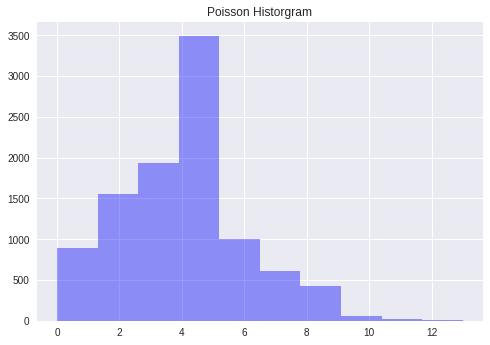

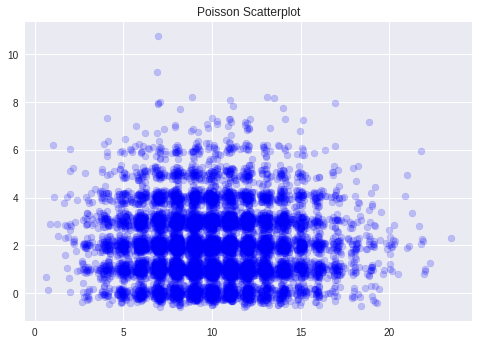

In [0]:
showHistorgram(poisson_sample, "Poisson")

noice = tf.random.normal(poisson_2d_sample.shape, stddev=0.2)
showScattered(poisson_2d_sample + noice, "Poisson")

# Normal Distribution

In [0]:
normal_dist = tfd.Normal(name="Normal Dist", loc=0., scale=1.)
normal_dist_2d = tfd.Normal(name="Normal Dist 2D", loc=[0., 10.], scale=1.)
print(normal_dist)

tfp.distributions.Normal("Normal Dist/", batch_shape=(), event_shape=(), dtype=float32)


In [0]:
normal_sample_size = 2500
normal_sample = normal_dist.sample(normal_sample_size)
normal_2d_sample = normal_dist_2d.sample(normal_sample_size)

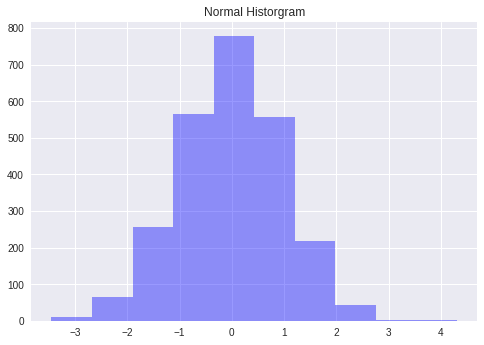

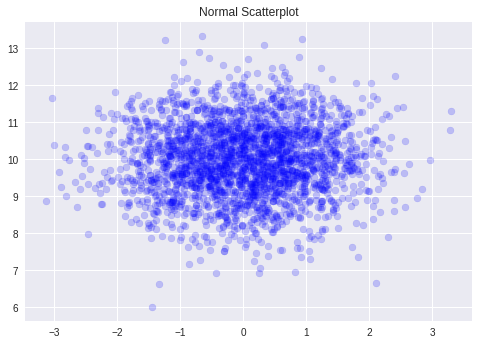

In [0]:
showHistorgram(normal_sample, name="Normal")

showScattered(normal_2d_sample, name="Normal")

# Multinomial Distribution

In [0]:
p = [.001, .3, .99999]
multinomial_dist = tfd.Multinomial(total_count=250., probs=p, name='One Multinomial')
multinomial_dist

<tfp.distributions.Multinomial 'One Multinomial/' batch_shape=() event_shape=(3,) dtype=float32>

In [0]:
multinomial_sample_size = 2500
multinomial_sample = multinomial_dist.sample(multinomial_sample_size)
print(multinomial_sample)

Instructions for updating:
Use tf.random.categorical instead.
tf.Tensor(
[[  0.  56. 194.]
 [  1.  72. 177.]
 [  0.  60. 190.]
 ...
 [  0.  53. 197.]
 [  0.  54. 196.]
 [  0.  50. 200.]], shape=(2500, 3), dtype=float32)


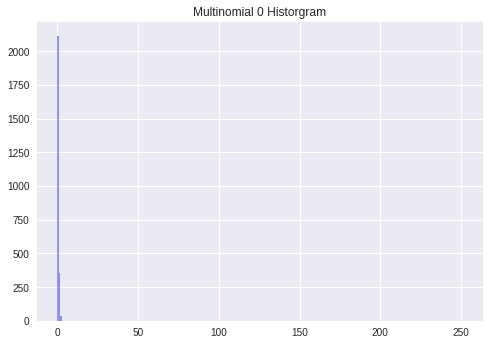

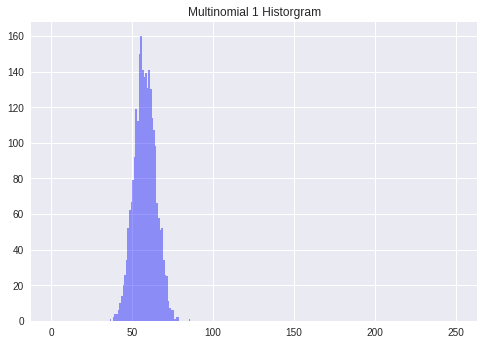

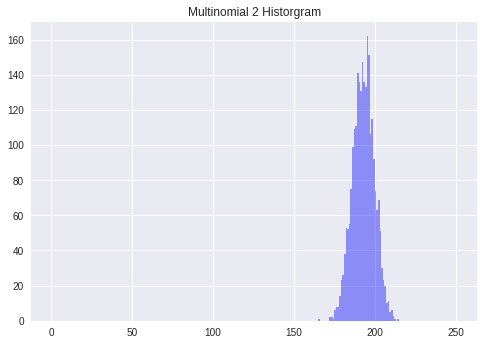

In [0]:
bins = [i for i in range(multinomial_dist.total_count + 2)]
showHistorgram(multinomial_sample[:, 0], name="Multinomial 0", bins=bins)
showHistorgram(multinomial_sample[:, 1], name="Multinomial 1", bins=bins)
showHistorgram(multinomial_sample[:, 2], name="Multinomial 2", bins=bins)

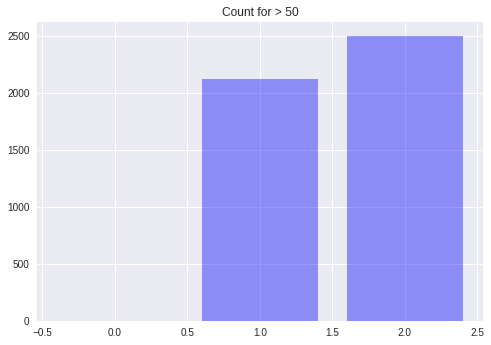

In [0]:
data = [0, 0, 0]
for i in range(3):
  data[i] = np.count_nonzero(multinomial_sample[:, i] > 50)

plt.bar([0, 1, 2], data, color='blue', alpha=0.4)
plt.title("Count for > 50")
plt.show()

# Bijectors
https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Reshape

In [0]:
reshape = tfp.bijectors.Reshape(event_shape_out=[1, 1,-1])

def describe_shape(arr):
  arr_t = reshape.forward(arr) 
  print("{} \t {} => {} \t {}".format(arr, np.array(arr).shape, arr_t, arr_t.shape))  

describe_shape([])
describe_shape([1])
describe_shape([1, 2])
describe_shape([[1]])
describe_shape([[1, 2, 3], [4, 5, 6]])


print(reshape.inverse(reshape.forward([1, 2])))

[] 	 (0,) => [] 	 (1, 1, 0)
[1] 	 (1,) => [[[1]]] 	 (1, 1, 1)
[1, 2] 	 (2,) => [[[1 2]]] 	 (1, 1, 2)
[[1]] 	 (1, 1) => [[[[1]]]] 	 (1, 1, 1, 1)
[[1, 2, 3], [4, 5, 6]] 	 (2, 3) => [[[[1 2 3]]]


 [[[4 5 6]]]] 	 (2, 1, 1, 3)
tf.Tensor([1 2], shape=(2,), dtype=int32)


# Probabilistic Models

with  Approximate Bayesian Computation (naive)

## Szenario

Randomly select products from a factory. Out of 50 draws 4 are faulty or damaged. 

## Question

 Is it likely that 4 out of 50 products are faulty? How can one describe its uncertainty.


## Information

What does the posterieur distribution look like when the prior distribution is uniform and the generative model is based on a binomial distribution.

In [0]:
def abc_simple(prior_dist, tested_total, tested_faulty, steps=1000, epsilon=2):
  '''Approximate Bayesian Computation (naive)'''

  # select rate from prior via sampling
  rates = prior_dist.sample(steps)


  # generative model distribution
  faulty_samples = []
  i = 0
  for rate in rates:
    if i % (int(steps / 10)) == 0:
      print("{}%".format("%.2f" % (100 * i / steps)))
    
    generative_model_dist = tfd.Multinomial(total_count=1, probs=[rate, 1-rate], name="generative model")
    sample = generative_model_dist.sample(tested_total)
    faulty_samples += [sum(sample[:, 0])]
    i += 1

  # ABC rejection algorithm
  results = []
  for [rate, computed_faulty] in zip(rates, faulty_samples):
    if (computed_faulty - tested_faulty) ** 2 > epsilon ** 2:
      continue

    results += [rate]

  return results

In [14]:
# known data
products_tested_total = 50
products_tested_faulty = 4
products_tested_good = products_tested_total - products_tested_faulty

# model steps
steps = 5000
epsilon = 1

# prior distribution
prior_dist = tfd.uniform.Uniform(name="prior")

# compute model
dist_result = abc_simple(prior_dist=prior_dist,
           tested_total=products_tested_total,
           tested_faulty=products_tested_faulty,
           steps=steps,
           epsilon=epsilon)

0.00%
10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%


Expected mean 8.0%
number of successful rates: 296
mean: 9.90%
std: 0.04


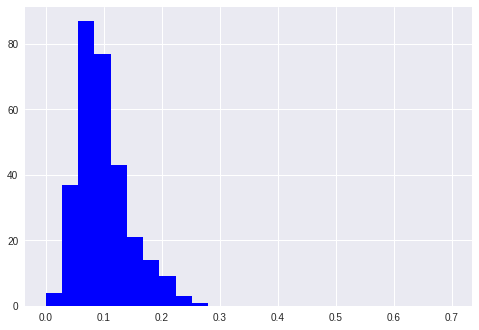

In [15]:
# evaluate model

np_dist_result = np.array(dist_result)

print("Expected mean {}%".format(100 * products_tested_faulty / products_tested_total))
print("number of successful rates: {}".format(len(dist_result)))

mean = sum(dist_result) / len(dist_result)
std = np.std(dist_result)
print("mean: {}%".format("%.2f" % (mean * 100)))
print("std: {}".format("%.2f" % std))

plt.hist(dist_result, color='blue', range=[0, 0.7], bins=25)
plt.show()

# Probabilistic Models

using the Hamiltonain algorithm: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo


In [0]:
total = 1000
faulty = 91

# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
  return -(x - (faulty / total))**2

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=1.,
    kernel=hmc)

mean:0.0790  stddev:0.7052


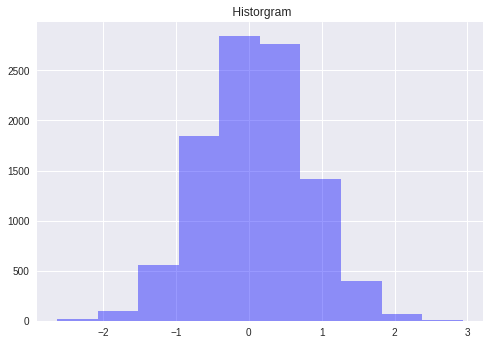

In [7]:
print('mean:{:.4f}  stddev:{:.4f}'.format(
    tf.reduce_mean(samples), tfp.stats.stddev(samples)))

showHistorgram(samples)